#Empirical Analysis of Put-Call Parity

**Goal:** Provide a reusable framework to test how put-call parity links theoretical Black-Scholes prices to market option quotes.  

**Approach**  
1. **Stock context**: Retrieve one year of price history and log returns for the chosen ticker (default `TICKER = "PEP"`, but users can substitute `"AAPL"`, `"MSFT"`, `"TSLA"`, etc.). Be sure to update r (risk-free rate) and q (dividend yield) if applicable.
2. **Theoretical parity**: Verify that $C - P = S e^{-qT} - K e^{-rT}$  
   holds under the Black-Scholes model with dividends across a range of strikes.  
3. **Market parity**: Pull an option chain for a selected expiry, compute $C-P$ from mid quotes, and compare observed deviations against a bid-ask tolerance band.  

**Key choices**  
- Notebook syncs to **live data**: ASOF is set to the most recent trading day, and EXPIRY defaults to the nearest available option maturity.  
- The framework is general and works for any ticker supported by Yahoo Finance.  
- Continuous compounding rates $(r, q)$ are applied, with dividend yield $q$ on the stock leg.  
- Users should note that intraday runs provide the cleanest option chain data. Running after hours will use end-of-day prices and quotes, which are still valid for analysis but may behave differently at illiquid strikes.  


In [11]:
#Parameters for Put-Call Parity Analysis

#Imports
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import norm

#Underlying stock ticker
TICKER = "PEP" #Change "PEP" to any valid Yahoo Finance ticker, e.g. "AAPL", "MSFT", "TSLA"

#Financial parameters (annualized, continuous compounding)
r = 0.044   #risk-free rate chosen based on US 3-month treasury yield as of Sept 2025, so update this if applicable
q = 0.0365  ##PepsiCo's forward annual dividend yield from Yahoo Finance as of Sept 2025, so update this if applicable

#Plotting defaults
plt.rcParams["figure.figsize"] = (9, 4.5)

#Sync to live market
tk = yf.Ticker(TICKER)

#Latest trading day & close for spot price
_hist = tk.history(period="5d")
_hist.index = pd.to_datetime(_hist.index).tz_localize(None) if _hist.index.tz is not None else pd.to_datetime(_hist.index)
ASOF = _hist.index[-1].strftime("%Y-%m-%d")
S0   = float(_hist["Close"].iloc[-1])

#Nearest available option expiry
_opts = tk.options
EXPIRY = _opts[0]

print("Configuration loaded (live sync):")
print(f" TICKER = {TICKER}")
print(f" ASOF   = {ASOF}")
print(f" S0     = {S0:.4f}")
print(f" EXPIRY = {EXPIRY}")
print(f" r      = {r}")
print(f" q      = {q}")

Configuration loaded (live sync):
 TICKER = AAPL
 ASOF   = 2025-09-11
 S0     = 230.0300
 EXPIRY = 2025-09-12
 r      = 0.044
 q      = 0.0365


##Part 1: Stock Context (Price & Log Returns)

**Motivation:** Since option pricing is tied to the underlying stock, it is essential to first review how the stock has recently behaved. This provides the market context for evaluating option chains.

**Method:** Collect one year of daily closing prices up to the analysis date (ASOF) and compute daily log returns. Plot both the stock's price path and its return series to observe trends and volatility patterns.

In [12]:
#Part 1: Stock Context (Price & Log Returns)

from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9, 4.5)

#Remove time zone for safe datetime comparisons
def _drop_tz(df: pd.DataFrame) -> pd.DataFrame:
    if not isinstance(df.index, pd.DatetimeIndex):
        return df
    try:
        df = df.copy()
        df.index = df.index.tz_localize(None)   #works if tz-aware
    except TypeError:
        #already tz-naive; nothing to do
        pass
    return df

#Retrieve spot price (S0) for the chosen ticker as of the ASOF date.
#Falls back to the most recent close if the date is not a trading day.
def get_spot_asof(ticker: str, asof_str: str) -> float:
    asof = datetime.fromisoformat(asof_str)
    start = (asof - timedelta(days=7)).strftime("%Y-%m-%d")
    end   = (asof + timedelta(days=1)).strftime("%Y-%m-%d")
    hist = yf.Ticker(ticker).history(start=start, end=end)
    hist = _drop_tz(hist)
    cutoff = pd.to_datetime(asof_str)          #tz-naive cutoff
    hist = hist[hist.index <= cutoff]
    if hist.empty:
        raise ValueError("No close found on/before ASOF; adjust ASOF/window.")
    return float(hist["Close"].iloc[-1])

S0 = get_spot_asof(TICKER, ASOF)
print(f"{TICKER} spot as of {ASOF}: S0 = {S0:.4f}")

#Collect one year of daily closes leading up to ASOF.
#This provides historical context for option pricing and volatility analysis.
UNDERLYING_CTX_YEARS = 1
asof_dt = datetime.fromisoformat(ASOF)
start = (asof_dt - timedelta(days=365 * UNDERLYING_CTX_YEARS + 10)).strftime("%Y-%m-%d")
end   = (asof_dt + timedelta(days=1)).strftime("%Y-%m-%d")

hist = yf.Ticker(TICKER).history(start=start, end=end)
hist = _drop_tz(hist)
cutoff = pd.to_datetime(ASOF)
hist = hist[hist.index <= cutoff].copy()

#Compute daily log returns to capture volatility patterns.
hist["LogRet"] = np.log(hist["Close"]).diff()

AAPL spot as of 2025-09-11: S0 = 230.0300


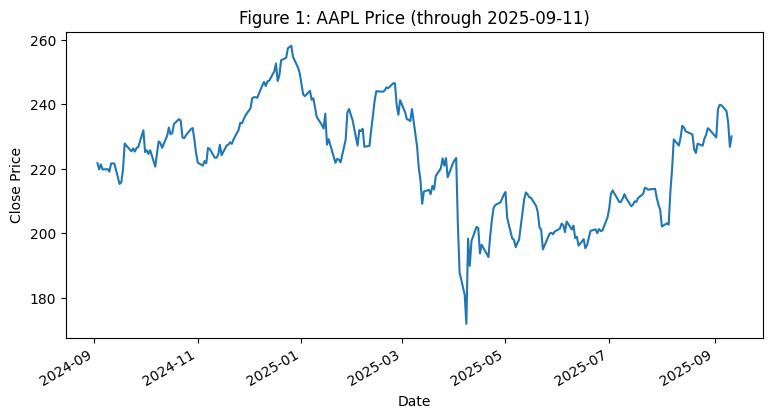

In [13]:
#Plot the stock price series up to ASOF.
ax = hist["Close"].plot(title = f"Figure 1: {TICKER} Price (through {ASOF})")
ax.set_xlabel("Date")
ax.set_ylabel("Close Price")
plt.show()

Figure 1 shows us the stock's spot price $(S_0)$ as of the analysis date and its path over the previous year. Stocks can go through periods of rising, falling, or moving sideways, and these trends affect how options are priced.

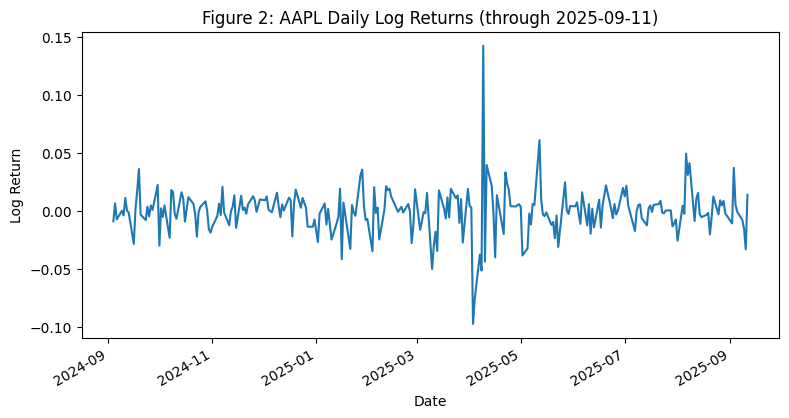

In [14]:
#Plot daily log returns to highlight volatility bursts.
ax = hist["LogRet"].plot(title = f"Figure 2: {TICKER} Daily Log Returns (through {ASOF})")
ax.set_xlabel("Date")
ax.set_ylabel("Log Return")
plt.show()

Figure 2 shows us the distribution of daily log returns. Most values will cluster near zero, but occasional spikes reveal high-volatility periods like earnings or market shocks. These bursts are key drivers of option valuations and deviations from put-call parity.

##Part 2: Theoretical Put-Call Parity (Black-Scholes with dividends)

**Motivation:** Before analyzing market option quotes, it is important to confirm that put-call parity holds in theory. This provides a clean benchmark, ensuring that the Black-Scholes model with dividends satisfies the parity relationship exactly, and that any later deviations come from market data rather than model error. You will verify that the parity relation holds to within numerical precision, typically on the order of $10^{-14}$.

**Method:** Compute the year fraction between the analysis date (ASOF) and the chosen option expiry. Using the stock's spot price along with fixed values for the risk-free rate and dividend yield, apply the Black-Scholes model to price calls and puts across a range of strikes. Then compare the left-hand ($C-P$) and right-hand ($S e^{-qT} - K e^{-rT}$) sides of the parity relation. In theory, they should be equal up to small numerical rounding differences.

,strike,C,P,lhs_C_minus_P,rhs_Se_qT_minus_Ke_rT,diff
0,161.020999,69.005407,6.048755e-165,69.005407,69.005407,0.0
1,166.771749,63.255351,1.157844e-134,63.255351,63.255351,0.0
2,172.522499,57.505294,2.304086e-108,57.505294,57.505294,0.0
3,178.273249,51.755237,1.089121e-85,51.755237,51.755237,0.0
4,184.023999,46.005180,2.551009e-66,46.005180,46.005180,0.0
5,189.774749,40.255124,5.713832e-50,40.255124,40.255124,0.0
6,195.525499,34.505067,2.210334e-36,34.505067,34.505067,0.0
7,201.276249,28.755010,2.522977e-25,28.755010,28.755010,0.0


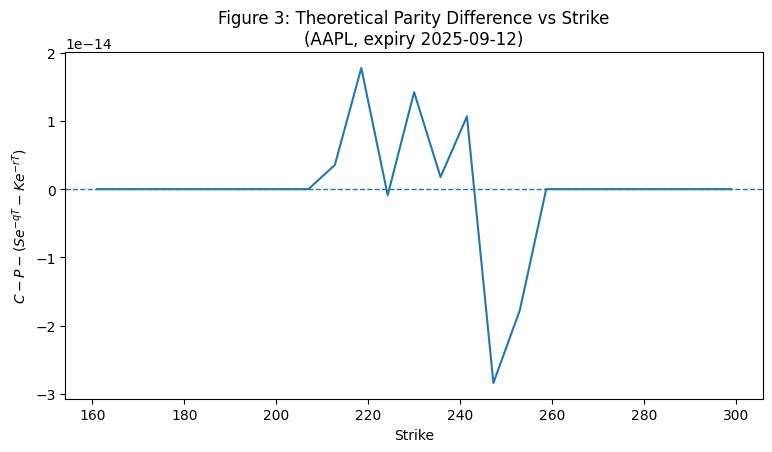

[Part 2] Max |parity diff| across strikes (theory): 2.842e-14 (numerical precision)


In [15]:
#Part 2: Theoretical Put–Call Parity (Black–Scholes with dividends)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

#Year fraction (ACT/365) between ASOF and EXPIRY for pricing horizon T
def yearfrac(asof_str: str, expiry_str: str) -> float:
    asof = datetime.fromisoformat(asof_str)
    exp  = datetime.fromisoformat(expiry_str)
    return (exp - asof).days / 365.0

T = yearfrac(ASOF, EXPIRY)

#Black–Scholes European call/put with continuous dividend yield q
def bs_call_put(S: float, K: float, r: float, q: float, T: float, sigma: float):
    """
    Returns (C, P) under Black–Scholes with continuous dividend yield q.
    Note: Volatility affects C and P but not whether the parity identity holds.
    """
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return (np.nan, np.nan)
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    C  = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    P  = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
    return (C, P)

#Build a strike grid around S0 and evaluate parity components under BS
SIGMA_THEORY = 0.25  #placeholder volatility for pricing visualization
K_grid = np.linspace(0.7 * S0, 1.3 * S0, 25)

rows = []
for K in K_grid:
    C, P = bs_call_put(S0, K, r, q, T, SIGMA_THEORY)
    lhs = C - P
    rhs = S0 * np.exp(-q * T) - K * np.exp(-r * T)
    rows.append({
        "strike": K,
        "C": C, "P": P,
        "lhs_C_minus_P": lhs,
        "rhs_Se_qT_minus_Ke_rT": rhs,
        "diff": lhs - rhs
    })

df_theory = pd.DataFrame(rows).sort_values("strike")
display(df_theory.head(8))

#Plot parity difference vs strike.
#This should be ~0 up to numerical precision.
fig, ax = plt.subplots()
ax.axhline(0.0, linestyle="--", linewidth=1)
ax.plot(df_theory["strike"], df_theory["diff"])
ax.set_title(f"Figure 3: Theoretical Parity Difference vs Strike\n({TICKER}, expiry {EXPIRY})")
ax.set_xlabel("Strike")
ax.set_ylabel(r"$C - P - (S e^{-qT} - K e^{-rT})$")
plt.show()

#Summary printout for the notebook log
max_abs_diff = float(df_theory["diff"].abs().max())
print(f"[Part 2] Max |parity diff| across strikes (theory): {max_abs_diff:.3e} (numerical precision)")

**Interpretation (Table):** The table preview includes call and put prices, $C-P$, and $S e^{-qT} - K e^{-rT}$. The `diff` column will usually display as zero because of rounding, but the true residuals should be at the level of machine precision $ \approx 10^{-14}$. This will validate that the pricing functions enforce parity correctly.

**Interpretation (Graph):** Figure 3 shows us the parity residuals across strikes for the chosen stock and expiry. Residuals should hover at zero with minimal differences (machine precision). This demonstrates that, in theory, Black-Scholes with dividends enforces put-call parity exactly. Any real deviations observed in market data must therefore come from trading frictions such as bid-ask spreads, stale quotes, or illiquidity.

##Part 3: Market Put-Call Parity

**Motivation:** After checking parity in theory, the next step is to test it with live market quotes. Differences you see are usually due to bid-ask spreads, stale quotes, or low liquidity, rather than a failure of parity.

**Method:** Pull the option chain for the selected expiry. Compute mid prices for calls and puts at each strike ($C_{mid} - P_{mid}$) and compare them to the theoretical right side ($S e^{-qT} - K e^{-rT}$). The orange dotted line represents the upper tolerance (+ band) and the green dotted line the lower tolerance (- band), which are the sum of call and put half-spreads.

,strike,C_mid,C_halfspread,P_mid,P_halfspread,lhs_mid,rhs_theory,diff,band
0,130.0,99.975,1.775,0.005,0.005,99.970,100.022667,-0.052667,1.780
1,140.0,90.225,1.575,0.005,0.005,90.220,90.023873,0.196127,1.580
2,150.0,80.225,1.575,0.005,0.005,80.220,80.025078,0.194922,1.580
3,160.0,70.050,1.750,0.005,0.005,70.045,70.026283,0.018717,1.755
4,175.0,55.100,0.850,0.045,0.045,55.055,55.028092,0.026908,0.895
5,180.0,50.325,0.625,0.005,0.005,50.320,50.028694,0.291306,0.630
6,185.0,45.125,0.825,0.010,0.010,45.115,45.029297,0.085703,0.835
7,190.0,40.175,0.825,0.005,0.005,40.170,40.029900,0.140100,0.830
8,195.0,35.050,0.450,0.005,0.005,35.045,35.030502,0.014498,0.455
9,200.0,30.150,0.300,0.010,0.010,30.140,30.031105,0.108895,0.310


Calls both-zero: 0 / 47
Puts  both-zero: 0 / 42


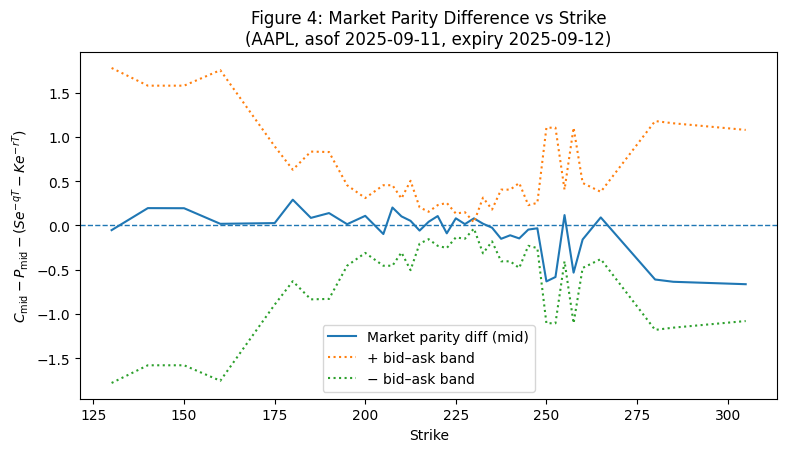

In [16]:
#Part 3: Market Put-Call Parity

T = yearfrac(ASOF, EXPIRY)
tk = yf.Ticker(TICKER)

#Pull option chain (calls & puts) for the chosen live expiry
chain = tk.option_chain(EXPIRY)
calls_raw = chain.calls.copy()
puts_raw  = chain.puts.copy()

#Raw mids
calls_raw["C_mid"] = (calls_raw["bid"] + calls_raw["ask"]) / 2.0
puts_raw["P_mid"]  = (puts_raw["bid"]  + puts_raw["ask"])  / 2.0

#Half-spreads for a visual tolerance band
calls_raw["C_halfspread"] = (calls_raw["ask"] - calls_raw["bid"]) / 2.0
puts_raw["P_halfspread"]  = (puts_raw["ask"]  - puts_raw["bid"])  / 2.0

#Merge by strike
m = pd.merge(
    calls_raw[["strike", "C_mid", "C_halfspread"]],
    puts_raw[["strike", "P_mid", "P_halfspread"]],
    on="strike", how="inner"
).sort_values("strike")

#Parity components
m["lhs_mid"] = m["C_mid"] - m["P_mid"]
m["rhs_theory"] = S0 * np.exp(-q * T) - m["strike"] * np.exp(-r * T)
m["diff"] = m["lhs_mid"] - m["rhs_theory"]
m["band"] = (m["C_halfspread"] + m["P_halfspread"]).astype(float)

#Quick peek + zero stats
display(m.head(10))
both_zero_calls = ((calls_raw["bid"]==0) & (calls_raw["ask"]==0)).sum()
both_zero_puts  = ((puts_raw["bid"]==0)  & (puts_raw["ask"]==0)).sum()
print(f"Calls both-zero: {both_zero_calls} / {len(calls_raw)}")
print(f"Puts  both-zero: {both_zero_puts} / {len(puts_raw)}")

#Plot raw parity deviation vs strike with bid–ask band
fig, ax = plt.subplots()
ax.axhline(0.0, linestyle="--", linewidth=1)
ax.plot(m["strike"], m["diff"], label="Market parity diff (mid)")
ax.plot(m["strike"],  m["band"], linestyle=":", label="+ bid–ask band")
ax.plot(m["strike"], -m["band"], linestyle=":", label="− bid–ask band")
ax.set_title(f"Figure 4: Market Parity Difference vs Strike\n({TICKER}, asof {ASOF}, expiry {EXPIRY})")
ax.set_xlabel("Strike")
ax.set_ylabel(r"$C_{\mathrm{mid}} - P_{\mathrm{mid}} - (S e^{-qT} - K e^{-rT})$")
ax.legend()
plt.show()

**Interpretation (Table):** The preview table lists strikes, mid call and put prices, half-spreads, the theoretical parity RHS, and the difference. Most `diff` values should be close to zero but not exact, since the market introduces frictions like bid-ask spreads. The `band` column shows the tolerance range implied by these spreads.

**Interpretation (Graph):** Figure 4 shows us the market parity differences across strikes for the selected stock and expiration. The solid blue line (mid-market diff) may fluctuate around zero, with the orange dotted line (upper tolerance) and green dotted line (lower tolerance) capturing the bid-ask band. If the blue line stays between the orange and green bands, the market is consistent with put-call parity. This means that apparent “violations” are explained by normal trading frictions rather than true arbitrage.

##Conclusion

**Project Findings:** This analysis demonstrates how to verify put-call parity on any stock with listed options.  


* In Part 1, you reviewed Pepsi's price history and daily log returns, establishing context for option valuation.
* In Part 2, you found whether theoretical parity holds to numerical precision, confirming that the Black-Scholes model with dividends enforces the relationship exactly.  
* In Part 3, you compared theoretical put-call parity to live market quotes. The observed differences should have fluctuated around zero but remained within the tolerance band implied by bid-ask spreads.

**Interpretation:** As long as the blue line (market diff) stays between the orange and green dotted bands, the market will be consistent with put-call parity once transaction costs are considered. If the blue line falls outside these bands, that would indicate a potential arbitrage opportunity to construct a risk-free profit by trading stock, calls, and puts. In practice, however, such violations are rare and fleeting. They are usually eliminated quickly by market makers or high-frequency traders, or absorbed into wider spreads that reflect trading frictions.  

**Takeaway:** Put-call parity is a robust theoretical identity. What appear to be "violations" are almost always explained by normal market frictions such as transaction costs, liquidity, and spreads rather than true arbitrage opportunities.